In [1]:
import numpy as np
import pandas as pd
import pyomo.environ as pyo
from measure_optimize import MeasurementOptimizer
import matplotlib.pyplot as plt
from itertools import permutations, product

In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Input Setting

In [3]:
jaco_info = pd.read_csv('./RotaryBed/Q22_scale.csv', index_col=False)

jaco_list = np.asarray(jaco_info)

jaco = []
for i in range(len(jaco_list)):
    jaco.append(list(jaco_list[i][1:]))
    
print(np.shape(jaco))

(308, 5)


In [4]:
number_measure = 14
number_t = 22
number_total = number_measure*number_t
cost = [1]*number_total

## FIM collection and Sigma INV

In [5]:
solution1 = [1]*number_total

In [6]:
calculator = MeasurementOptimizer(jaco, number_measure, number_t, cost, verbose=True)

fim_expect = calculator.fim_computation()

calculator.compute_FIM(solution1)

Q shape: 308 5
======FIM result======
FIM: [[ 1.12672079e+03  1.99620709e+00 -8.27109148e+02  2.23307383e+03
  -1.27981839e+02]
 [ 1.99620709e+00  1.18589056e+00 -2.94047895e-01  1.63272938e+01
  -3.30259408e+00]
 [-8.27109148e+02 -2.94047895e-01  6.68554142e+02 -1.72703074e+03
   3.26205209e+01]
 [ 2.23307383e+03  1.63272938e+01 -1.72703074e+03  5.20782946e+03
  -2.12490410e+02]
 [-1.27981839e+02 -3.30259408e+00  3.26205209e+01 -2.12490410e+02
   1.16854209e+02]]
Determinant: 1435753590.9147868 ; log_e(det): 21.084955698778014 ; log_10(det): 9.157079911153815
Trace: 7121.144491083985 ; log_e(trace): 8.870823734618002 ; log_10(trace): 3.852549797880995
Min eig: 0.8358678444970318 ; log_e(min_eig): -0.17928475913869069 ; log_10(min_eig): -0.07786238158328697
Cond: 8134.8284627660305


array([[ 1.12672079e+03,  1.99620709e+00, -8.27109148e+02,
         2.23307383e+03, -1.27981839e+02],
       [ 1.99620709e+00,  1.18589056e+00, -2.94047895e-01,
         1.63272938e+01, -3.30259408e+00],
       [-8.27109148e+02, -2.94047895e-01,  6.68554142e+02,
        -1.72703074e+03,  3.26205209e+01],
       [ 2.23307383e+03,  1.63272938e+01, -1.72703074e+03,
         5.20782946e+03, -2.12490410e+02],
       [-1.27981839e+02, -3.30259408e+00,  3.26205209e+01,
        -2.12490410e+02,  1.16854209e+02]])

In [7]:
def sgn(p):
    """
    Give the signature of a permutation

    Parameters:
    -----------
    p: the permutation (a list)

    Return:
    ------
    1 if the number of exchange is an even number
    -1 if the number is an odd number
    """

    if len(p) == 1:
        return 1

    trans = 0

    for i in range(0, len(p)):
        j = i + 1

        for j in range(j, len(p)):
            if p[i] > p[j]:
                trans = trans + 1

    if (trans % 2) == 0:
        return 1
    else:
        return -1

In [8]:
def compute_FIM(numRes, FIMSet, obj="A", fix=False, budget=100):
    
    m = pyo.ConcreteModel()
    
    m.NumRes = pyo.Set(initialize=range(numRes))
    m.DimFIM = pyo.Set(initialize=range(len(FIMSet[0])))
    print(m.DimFIM)
    
    # set up y and cov y 
    #m.y = pyo.Var(m.NumRes, initialize=0.1, bounds=(0,1), within = pyo.NonNegativeReals)
    def identity(m, a, b):
        return 1 if a==b else 0

    m.cov_y = pyo.Var(m.NumRes, m.NumRes, initialize=identity, bounds=(0,1), within=pyo.NonNegativeReals)
    
    if fix:
        m.cov_y.fix()
    
    # set up FIM
    m.TotalFIM = pyo.Var(m.DimFIM, m.DimFIM, initialize=1)

    # compute FIM
    def eval_fim(m, a, b):
        return m.TotalFIM[a,b] == sum(m.cov_y[i,j]*FIMSet[i*numRes+j][a][b] for i in range(numRes) for j in range(numRes))
    
    
    # y and conv y constraints
    def y_covy1(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[a, a]
    
    def y_covy2(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[b, b]
    
    def y_covy3(m, a, b):
        return m.cov_y[a, b] >= m.cov_y[a, a] + m.cov_y[b, b] - 1
    
    def y_covy4(m, a, b):
        '''
        Avoid duplication
        '''
        if a>b:
            return m.cov_y[a, b] == m.cov_y[b, a]
        
        else:
            return pyo.Constraint.Skip
    
    
    
    def cost_compute(m):
        return m.cost == sum(m.cov_y[i,i] for i in range(numRes))
    
    def cost_limit(m):
        return m.cost <= budget
    
    # set up Design criterion
    def ComputeTrace(m):
        sum_x = sum(m.TotalFIM[j,j] for j in m.DimFIM)
        return sum_x
    
    
    def ComputeDet(m):
        """Calculate determinant. Can be applied to FIM of any size.
        det(A) = sum_{\sigma \in \S_n} (sgn(\sigma) * \Prod_{i=1}^n a_{i,\sigma_i})
        Use permutation() to get permutations, sgn() to get signature
        """

        r_list = list(range(len(m.DimFIM)))
        # get all permutations
        object_p = permutations(r_list)
        list_p = list(object_p)

        # generate a name_order to iterate \sigma_i
        det_perm = 0
        for i in range(len(list_p)):
            name_order = []
            x_order = list_p[i]
            # sigma_i is the value in the i-th position after the reordering \sigma
            for x in range(len(x_order)):
                for y, element in enumerate(m.DimFIM):
                    if x_order[x] == y:
                        name_order.append(element)

            det_perm += sgn(list_p[i]) * (m.TotalFIM[0,name_order[0]] *m.TotalFIM[1,name_order[1]]*m.TotalFIM[2,name_order[2]]*m.TotalFIM[3,name_order[3]]*m.TotalFIM[4,name_order[4]])

        return det_perm
    
    
    # add constraints
    m.TotalFIM_con = pyo.Constraint(m.DimFIM, m.DimFIM, rule=eval_fim)
    
    if not fix:
        m.cov1 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy1)
        m.cov2 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy2)
        m.cov3 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy3)
        m.cov4 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy4)
        
        m.cost = pyo.Var(initialize=budget)
        m.cost_compute = pyo.Constraint(rule=cost_compute)
        m.budget_limit = pyo.Constraint(rule=cost_limit)
    
    # set objective 
    if obj == "A":
        m.Obj = pyo.Objective(rule=ComputeTrace, sense=pyo.maximize)    
    elif obj =="D":
        m.Obj = pyo.Objective(rule=ComputeDet, sense=pyo.maximize)
    
    return m 

In [9]:
def compute_FIM(numRes, FIMSet, obj="A", fix=False, budget=100):
    
    m = pyo.ConcreteModel()
    
    m.NumRes = pyo.Set(initialize=range(numRes))
    m.DimFIM = pyo.Set(initialize=range(len(FIMSet[0])))
    print(m.DimFIM)
    
    # set up y and cov y 
    #m.y = pyo.Var(m.NumRes, initialize=0.1, bounds=(0,1), within = pyo.NonNegativeReals)
    def identity(m, a, b):
        return 1 if a==b else 0

    m.cov_y = pyo.Var(m.NumRes, m.NumRes, initialize=identity, bounds=(0,1), within=pyo.NonNegativeReals)
    
    if fix:
        m.cov_y.fix()
    
    # set up FIM
    m.TotalFIM = pyo.Var(m.DimFIM, m.DimFIM, initialize=1)

    # compute FIM
    def eval_fim(m, a, b):
        return m.TotalFIM[a,b] == sum(m.cov_y[i,j]*FIMSet[i*numRes+j][a][b] for i in range(numRes) for j in range(numRes))
    
    
    # y and conv y constraints
    def y_covy1(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[a, a]
    
    def y_covy2(m, a, b):
        return m.cov_y[a, b] <= m.cov_y[b, b]
    
    def y_covy3(m, a, b):
        return m.cov_y[a, b] >= m.cov_y[a, a] + m.cov_y[b, b] - 1
    
    def y_covy4(m, a, b):
        '''
        Avoid duplication
        '''
        if a>b:
            return m.cov_y[a, b] == m.cov_y[b, a]
        
        else:
            return pyo.Constraint.Skip
    
    
    
    def cost_compute(m):
        return m.cost == sum(m.cov_y[i,i] for i in range(numRes))
    
    def cost_limit(m):
        return m.cost <= budget
    
    # set up Design criterion
    def ComputeTrace(m):
        sum_x = sum(m.TotalFIM[j,j] for j in m.DimFIM)
        return sum_x
    
    
    def ComputeDet(m):
        """Calculate determinant. Can be applied to FIM of any size.
        det(A) = sum_{\sigma \in \S_n} (sgn(\sigma) * \Prod_{i=1}^n a_{i,\sigma_i})
        Use permutation() to get permutations, sgn() to get signature
        """

        r_list = list(range(len(m.DimFIM)))
        # get all permutations
        object_p = permutations(r_list)
        list_p = list(object_p)

        # generate a name_order to iterate \sigma_i
        det_perm = 0
        for i in range(len(list_p)):
            name_order = []
            x_order = list_p[i]
            # sigma_i is the value in the i-th position after the reordering \sigma
            for x in range(len(x_order)):
                for y, element in enumerate(m.DimFIM):
                    if x_order[x] == y:
                        name_order.append(element)

            det_perm += sgn(list_p[i]) * (m.TotalFIM[0,name_order[0]] *m.TotalFIM[1,name_order[1]]*m.TotalFIM[2,name_order[2]]*m.TotalFIM[3,name_order[3]]*m.TotalFIM[4,name_order[4]])

        return det_perm
    
    
    # add constraints
    m.TotalFIM_con = pyo.Constraint(m.DimFIM, m.DimFIM, rule=eval_fim)
    
    if not fix:
        m.cov1 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy1)
        m.cov2 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy2)
        m.cov3 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy3)
        m.cov4 = pyo.Constraint(m.NumRes, m.NumRes, rule=y_covy4)
        
        m.cost = pyo.Var(initialize=budget)
        m.cost_compute = pyo.Constraint(rule=cost_compute)
        m.budget_limit = pyo.Constraint(rule=cost_limit)
    
    # set objective 
    if obj == "A":
        m.Obj = pyo.Objective(rule=ComputeTrace, sense=pyo.maximize)    
    elif obj =="D":
        m.Obj = pyo.Objective(rule=ComputeDet, sense=pyo.maximize)
    
    return m 

In [10]:
total_mea = 14*22

In [11]:
mod = compute_FIM(total_mea, calculator.fim_collection, obj="A", fix=False, budget=310)

solver = pyo.SolverFactory('ipopt')
solver.options['linear_solver'] = 'ma57'
solver.solve(mod, tee=True)

DimFIM
Ipopt 3.13.2: linear_solver=ma57


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
      

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 331897, 'Number of variables': 94890, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.13.2\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 26.97622847557068}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [12]:
print(pyo.value(mod.Obj))

7121.143675102459


In [13]:
### FIM
fim_result = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        fim_result[i,j] = pyo.value(mod.TotalFIM[i,j])
        
print(pyo.value(mod.TotalFIM[0,0]))
        
print(fim_result)
print('trace:', np.trace(fim_result))
print('det:', np.linalg.det(fim_result))

1126.7206925783785
[[ 1.12672069e+03  1.99620345e+00 -8.27109182e+02  2.23307380e+03
  -1.27981736e+02]
 [ 1.99620345e+00  1.18588100e+00 -2.94049858e-01  1.63272781e+01
  -3.30259025e+00]
 [-8.27109182e+02 -2.94049858e-01  6.68554095e+02 -1.72703071e+03
   3.26205554e+01]
 [ 2.23307380e+03  1.63272781e+01 -1.72703071e+03  5.20782896e+03
  -2.12490343e+02]
 [-1.27981736e+02 -3.30259025e+00  3.26205554e+01 -2.12490343e+02
   1.16854042e+02]]
trace: 7121.143675102459
det: 1435729890.462704


In [14]:
ans_y = np.zeros((total_mea,total_mea))


#for i in range(70):
    #print('Measurement', i, ':', pyo.value(mod.cov_y[i,i]))
    
for i in range(total_mea):
    for j in range(i, total_mea):
        cov = pyo.value(mod.cov_y[i,j])
        ans_y[i,j] = cov 
        ans_y[j,i] = pyo.value(mod.cov_y[j,i])
        
        if abs(pyo.value(mod.cov_y[i,j]) - pyo.value(mod.cov_y[j,i])) > 0.01:
            print('Wrong symmetry:', i, j, pyo.value(mod.cov_y[i,j]), pyo.value(mod.cov_y[j,i]))
        
        if abs(cov- min(pyo.value(mod.cov_y[i,i]), pyo.value(mod.cov_y[j,j]))) > 0.01:
            print('Wrong computation for covariance y:', i, j, pyo.value(mod.cov_y[i,i]), pyo.value(mod.cov_y[j,j]), cov)
#print(pyo.value(mod.cov_y[5,8]))
    
print(pyo.value(mod.cost))

Wrong computation for covariance y: 108 118 0.7188462500124959 0.33282356905587307 0.1783024699473305
Wrong computation for covariance y: 108 175 0.7188462500124959 0.332823568769858 0.1783024698783663
Wrong computation for covariance y: 118 175 0.33282356905587307 0.332823568769858 0.11949181843373892
306.33888870612685


[[0.99999931 0.99999895 0.9999988  ... 0.99999697 0.99999568 0.99999629]
 [0.99999895 0.99999947 0.99999894 ... 0.99999707 0.99999578 0.99999639]
 [0.9999988  0.99999894 0.99999929 ... 0.99999696 0.99999567 0.99999628]
 ...
 [0.99999697 0.99999707 0.99999696 ... 0.99999736 0.99999434 0.99999489]
 [0.99999568 0.99999578 0.99999567 ... 0.99999434 0.99999606 0.99999378]
 [0.99999629 0.99999639 0.99999628 ... 0.99999489 0.99999378 0.99999667]]


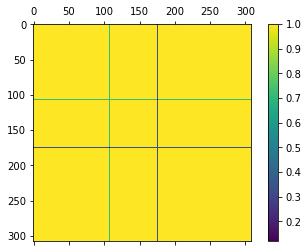

In [15]:
print(ans_y)

figure = plt.figure()
axes = figure.add_subplot(111)

caxes = axes.matshow(ans_y, interpolation='nearest')
figure.colorbar(caxes)

plt.show()

In [16]:
sol_y = np.asarray([ans_y[i,i] for i in range(total_mea)])

sol_y = np.reshape(sol_y, (14,5))
np.around(sol_y)
print(sol_y)

ValueError: cannot reshape array of size 308 into shape (14,5)

In [ ]:
import matplotlib

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)
        
        
    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [ ]:
measure_name = ['Ads.gas_inlet.F', 'Ads.gas_outlet.F', 'Ads.gas_outlet.T', 'Ads.gas_outlet.z("CO2")', 'Des.gas_inlet.F', 'Des.gas_outlet.F', 'Des.gas_outlet.T', 'Des.gas_outlet.z("CO2")', 'Ads.T_g.Value(19,10)', 'Ads.T_g.Value(23,10)', 'Ads.T_g.Value(28,10)', 'Ads.z("CO2",19,10)', 'Ads.z("CO2",23,10)', 'Ads.z("CO2",28,10)']

time_set = ['500', '1000', '1500', '2000', '2200']
#time_set = np.linspace(100, 2200, 22)
time_set = [str(i) for i in time_set]

fig, ax = plt.subplots(figsize=(16,8))

im, cbar = heatmap(sol_y, measure_name, time_set, ax=ax,
                   cmap="YlGn", cbarlabel="weight")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [ ]:
def plot_data(budget, a_cri, d_cri, design_cri_label):
    sense = []

    #plt.scatter(budget, np.log10(a_cri), s=50, color='red', label='A-optimality')
    plt.scatter(budget, np.log10(d_cri), marker='v', s=50, color='blue', label='D-optimality')
    plt.xlabel('Budget')
    plt.ylabel('log10(' + design_cri_label + ')')
    plt.legend()

    plt.show()

In [ ]:
a_set = [869.53, 1496.64, 1538.93, 1563.76, 1567.70, 1569.73, 1571.23]
d_set = [140.57, 2852.58, 11349.32, 23168.51, 30715.88, 34988.78, 36029.47]

plot_data([10,20,30,40,50,60,70], a_set, d_set, 'Determinant')